In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from skimage.transform import resize
from scipy.ndimage.interpolation import shift
import pandas as pd
import regex as re
import random

In [2]:
df = pd.read_csv (r'/Users/connerlusk/Desktop/Segmentation2/cleaned_data.csv')
test = df["Correct Label"][100]

In [3]:
#cleans the inputed dirty string and cleans it
def clean_string(string_of_labels):
    list_of_numbers = [int(s) for s in re.findall(r'\b\d+\b', string_of_labels)]
    removed_zeros = []
    for element in list_of_numbers:
        if element !=0:
            element = str(element)
            element = "0." + element
            removed_zeros.append(float(element))
    return [int(element * 255) for element in removed_zeros]

In [4]:
# creates a copy of the list where each number is 5 times larger
def increase_image_size(list_of_ints):
    return [int(element * 5) for element in list_of_ints]

In [5]:
#creates a dictionary with either x or ys as the key
def create_dict(direction, list_of_coordinate):
    final_dict = {}
    iterations = 0
    if direction == "x":
        while iterations < len(list_of_coordinate):
            key = list_of_coordinate[iterations]
            value = list_of_coordinate[iterations + 1]
            if key in final_dict:
                final_dict[key].append(value)
                iterations += 2
            else:
                final_dict[key] = [value]
                iterations +=2
    else:
        while iterations < len(list_of_coordinate):
            value = list_of_coordinate[iterations]
            key = list_of_coordinate[iterations + 1]
            if key in final_dict:
                final_dict[key].append(value)
                iterations += 2
            else:
                final_dict[key] = [value]
                iterations +=2
    return final_dict

In [6]:
# tells whether there is a gap in the data
def is_gap(array):
    iteration = 0
    array_return = []
    while iteration < len(array)-1:
        y1 = array[iteration]
        y2 = array[iteration + 1]
        if abs(y1 - y2) > 30:
            array_return.append(int((y1+y2)/2))
        iteration +=1
    return array_return

In [7]:
#makes a dictioary with the gaps in the data
def find_gap(x_dict, y_dict):
    dict_split_vals = {"x_coor":[],"y_coor":[]}
    dict_split_vals["x_coor"].extend(is_gap(sorted(y_dict)))
    dict_split_vals["y_coor"].extend(is_gap(sorted(x_dict)))
    return dict_split_vals

In [8]:
# splits an image
def split_image(dictionary, image,dict_name):
    coordinate = int(dictionary[dict_name][0]/5)
    shape = image.shape
    columns = shape[0]
    row = shape[1]
    if dict_name == "x_coor":
        new_image = image[:,0:coordinate]
        new_image2 = image[:,coordinate::]
        size = [(coordinate,columns),(row-coordinate,columns)]
    else:
        new_image = image[0:coordinate,:]
        new_image2 = image[coordinate::,:]
        size = [(columns,coordinate),(row-columns,row-coordinate)]
    return [new_image,new_image2], size

In [9]:
#gives images and split images if needed
def split_images(dictionary_of_gaps,image):
    images = []
    x_images = []
    y_images = []
    size = []
    if len(dictionary_of_gaps["x_coor"]) + len(dictionary_of_gaps["y_coor"]) == 0:
        images.append(image)
        size.append(image.shape)
    elif len(dictionary_of_gaps["x_coor"]) > 0:
        return_images = split_image(dictionary_of_gaps,image,"x_coor")
        images.extend(return_images[0])
        size.extend(return_images[1])
    elif len(dictionary_of_gaps["x_coor"]) > 0 and len(dictionary_of_gaps["y_coor"]) > 0:
        for x_image in x_images:
            return_images = split_image(dictionary_of_gaps,x_image,"y_coor")
            images.extend(return_images[0])
            size.extend(return_images[1])
    elif len(dictionary_of_gaps["y_coor"]) > 0:
        return_images = split_image(dictionary_of_gaps,image,"y_coor")
        images.extend(return_images[0])
        size.extend(return_images[1])
    return images,size

In [10]:
# changes an array to a list
def array_to_list(array):
    flatten = array.flatten()
    column = array.shape[1]
    end = array.size
    counter = 0
    end_list = []
    while counter < end:
        if flatten[counter] == 1:
            x = counter // column
            y = counter % column
            end_list.append(x)
            end_list.append(y)
        counter +=1
    return end_list

In [11]:
# changes a list to a dictionary
def list_to_dictionary(a_list):
    dictionary = {}
    iters = 0
    while iters < len(a_list):
        y = a_list[iters]
        x = a_list[iters+1]
        if x in dictionary:
            dictionary[x].append(y)
            iters +=2
        else:
            dictionary[x] = [y]
            iters +=2
    return dictionary

In [12]:
# adds skipped values to a dictionary
def add_empty(dictionary):
    start = min(dictionary)
    end = max(dictionary)
    while start < end:
        if start not in dictionary:
            dictionary[start] = []
        start +=1
    return dictionary

In [13]:
# fills the boundary of an image
def fill_boundary(dictionary):
    start = min(dictionary) + 1
    end = max(dictionary)
    while start <= end:
        if start == min(dictionary) + 1:
            if len(dictionary[start]) == 1:
                prev_value = dictionary[min(dictionary)][0]
                dif = prev_value - dictionary[start][0]
                if dif > 0:
                    dictionary[start].append(prev_value - dif)
                else:
                    dictionary[start].append(prev_value + dif)
            if len(dictionary[start]) ==0:
                dictionary[start].append(dictionary[min(dictionary)][0] + 3)
                dictionary[start].append(dictionary[min(dictionary)][0] - 3)
        elif start == max(dictionary):
            min_prev = min(dictionary[start-1])
            max_prev = max(dictionary[start-1])
            avg_prev = int((min_prev+max_prev)/2)
            dictionary[start] = [avg_prev]
        else:
            if len(dictionary[start]) ==1:
                val = dictionary[start][0]
                prev_max = max(dictionary[start-1])
                prev_min = min(dictionary[start-1])
                if prev_min > val:
                    dictionary[start].append(prev_max)
                elif prev_max < val:
                    dictionary[start].append(prev_min)
                else:
                    prev_avg = int((prev_max+prev_min)/2)
                    dictionary[start].append(prev_avg)   
            elif len(dictionary[start]) ==0:
                min1 = min(dictionary[start-1]) 
                max1 = max(dictionary[start-1])
                min2 = min(dictionary[start-2]) 
                max2 = max(dictionary[start-2])
                min_avg = int((min1+min2)/2)
                max_avg = int((max1+max2)/2)
                dictionary[start].append(min_avg)      
                dictionary[start].append(max_avg)      
        start +=1
    return dictionary

In [14]:
# makes sure the boundary is intact
def check_in_line(dictionary):
    iters = min(dictionary) + 3
    iters_max = max(dictionary)
    while iters < iters_max-2:
        prev_iter_min = min(dictionary[iters-3])
        prev_iter_max = max(dictionary[iters-3])
        iter_min = min(dictionary[iters])
        iter_max = max(dictionary[iters])
        next_iter_min = min(dictionary[iters+3])
        next_iter_max = max(dictionary[iters+3])
        avg_iter_min = int((prev_iter_min + next_iter_min)/2)
        avg_iter_max = int((prev_iter_max + next_iter_max)/2)
        if not prev_iter_min < iter_min < next_iter_max and not prev_iter_max < iter_max < next_iter_max:
            dictionary[iters] = [avg_iter_min,avg_iter_max]
        elif not prev_iter_min < iter_min < next_iter_max and not prev_iter_max < iter_max < next_iter_max:
            dictionary[iters] = [iter_min,avg_iter_max]
        elif prev_iter_min < iter_min < next_iter_max and prev_iter_max < iter_max < next_iter_max:
            dictionary[iters] = [avg_iter_min,iter_max]
        iters +=1
    return dictionary

In [15]:
# turns a dictionary into a list
def dictionary_to_list(dictionary):
    iteration = min(dictionary)
    end = max(dictionary)
    finished_list = []
    while iteration <= end:
        for element in dictionary[iteration]:
            finished_list.append(iteration)
            finished_list.append(element)
        iteration +=1
    return finished_list

In [16]:
# turns a list into an image
def list_to_image(list_of_pixels,size):
    image = np.zeros(size)
    count = 0
    while count < len(list_of_pixels):
        image[int(list_of_pixels[count]),int(list_of_pixels[count+1])] = 1
        count +=2
    return image

In [17]:
# finds the indexes of pixels
def find_indexs(image_slice):
    indexs = [];
    for i, j in enumerate(image_slice):
        if j != 0:
            indexs.append(i)
    return indexs

In [18]:
# fills in the boundary
def fill_data(array):
    shape = array.shape
    width = shape[0]
    array = array.flatten("F")
    size = array.size
    count = 0
    while count < size:
        current_slice = array[count:count+width]
        indexs = find_indexs(current_slice)
        if len(indexs) != 0:
            start_index = min(indexs)
            end_index = max(indexs)
            current_slice[start_index:end_index] = 1
            array[count:count+width] = current_slice
        count += width
    return array.reshape(shape,order='F')

In [19]:
def combine_images(list_images):
    image_1 = list_images[0]
    image_2 = list_images[1]
    image_1 = np.transpose(image_1)
    image_2 = np.transpose(image_2)
    final_image = np.hstack((image_1, image_2))
    return final_image

In [20]:
def create_segmentation(string):
    list_of_ints = clean_string(string)
    enlarged_image = increase_image_size(list_of_ints)
    dict_x = create_dict("x",enlarged_image)
    dict_y = create_dict("y",enlarged_image)
    base_image = list_to_image(list_of_ints,(256,256))
    gaps = find_gap(dict_x,dict_y)
    list_split_image = split_images(gaps,base_image)[0]
    sizes = split_images(gaps,base_image)[1]
    finished_images = []
    for n, a_split_image in enumerate(list_split_image):
        list_image = array_to_list(a_split_image)
        dictionary_image = list_to_dictionary(list_image)
        dictionary_added_empty = add_empty(dictionary_image)
        dictionary_with_boundary = fill_boundary(dictionary_added_empty)
        dictionary_checked_boundary = check_in_line(dictionary_with_boundary)
        finished_list = dictionary_to_list(dictionary_checked_boundary)
        finished_image = list_to_image(finished_list,sizes[n])
        filled_image = fill_data(finished_image)
        finished_images.append(filled_image)
    if len(finished_images) > 1:
        final_image = combine_images(finished_images)
    elif len(finished_images) == 1:
        final_image = finished_images[0] 
    return resize(final_image,(512,512))

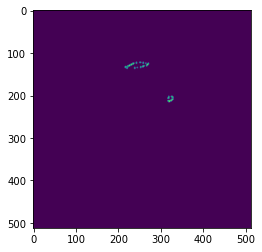

In [21]:
#start image
plt.imshow(resize(list_to_image(clean_string(test),(256,256)),(512,512)))

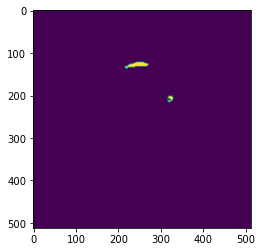

In [22]:
#end image
plt.imshow(create_segmentation(test))